#  Short-term trading strategy on G10 currencies
## Nb 7 - Training and testing



In this workbook we're choosing the right ML algorithms based on cross validation, building an ensemple and testing it.

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath(r'K:\2020_2431\q\fx_g10_st')
sys.path.append(path_to_project)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import WQUcapstoneCode.ml.ml as wqu
#from WQUcapstoneCode.ml.ml import cv_with_custom_score, train_valid_test_split, get_pyfolio_simple_tear_sheet
#https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/src/features/snippets.py
#https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/issues/6
#https://blog.fearcat.in/a?ID=01600-ba73e2bc-c45c-40c8-83ec-3e9749ab89cc
#https://github.com/schigrinov/capstone

import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import pyfolio as pf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection._split import _BaseKFold
from sklearn.metrics import *


def get_feature_types(X_train, Y_train, \
                      rfc = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', \
                                                   bootstrap=False, random_state=1)): # these are RF parameters recommended in the book)
    all_feature_cols = list(X_train.columns)
    frdif_feature_dict = {c[:-6]: c for c in all_feature_cols if c[-5:] == 'frdif'}
    ex_frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.values()]
    frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.keys()]

    rfc.fit(X_train,Y_train)
    # selecting the most important features
    feat_imp = pd.DataFrame({'Importance':rfc.feature_importances_})
    feat_imp['feature'] = X_train.columns
    top_feat = list(feat_imp[feat_imp.Importance>0.01].feature)

    return all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat


def get_pyfolio_simple_tear_sheet(mdl,X_tr, Y_tr, X_tst, Y_tst, rtns_actual):
    mdl.fit(X_tr, Y_tr)
    predicted_labels = pd.Series(mdl.predict(X_tst), index = Y_tst.index)
    rtns = predicted_labels * rtns_actual
    pf.create_simple_tear_sheet(rtns)


def train_valid_test_split(data, proportions='50:25:25'):
    """
    Splits the data into 3 parts - training, validation and test sets
    :param proportions: proportions for the split, like 2:1:1 or 50:30:20
    :param data: preprocessed data
    :return: X_train, Y_train, target_rtns_train, X_valid, Y_valid, target_rtns_valid, X_test, Y_test, target_rtns_test
    """
    features = [c for c in data.columns if c not in ('ret','bin')]
    n = len(data)
    borders = [float(p) for p in proportions.split(':')]
    borders = borders / np.sum(borders)

    train_ids = (0, int(np.floor(n * borders[0])))
    valid_ids = (train_ids[1] + 1, int(np.floor(n * np.sum(borders[:2]))))
    test_ids = (valid_ids[1] + 1, n)

    X_train = data[features].iloc[train_ids[0]:train_ids[1], :]
    X_valid = data[features].iloc[valid_ids[0]:valid_ids[1], :]
    X_test = data[features].iloc[test_ids[0]:test_ids[1], :]

    Y_train = data.bin.iloc[train_ids[0]:train_ids[1]]
    Y_valid = data.bin.iloc[valid_ids[0]:valid_ids[1]]
    Y_test = data.bin.iloc[test_ids[0]:test_ids[1]]

    target_rtns_train = data.ret.iloc[train_ids[0]:train_ids[1]]
    target_rtns_valid = data.ret.iloc[valid_ids[0]:valid_ids[1]]
    target_rtns_test = data.ret.iloc[test_ids[0]:test_ids[1]]

    return X_train, Y_train, target_rtns_train, X_valid, Y_valid, target_rtns_valid, X_test, Y_test, target_rtns_test



def cv_split(size, n_splits=3):
    indices = np.arange(size)
    test_starts = [
        (i[0], i[-1] + 1) for i in np.array_split(np.arange(size), n_splits)
    ]

    for i, j in test_starts:
        test_indices = indices[i:j]
        train_indices = np.array(list(set(indices) - set(test_indices)))
        yield  train_indices, test_indices


# TODO: can be easily improved using numba
def cv_with_custom_score(mdl, X, Y, rtn, n_folds=3):
    '''
    Calculates average annualised daily return and sharp ratio based pn cross-validation
    (result may be different from pyfolio, but good enough for our purpose)
    :param mdl: model
    :param X: features
    :param Y: labels
    :param rtn: returns
    :param n_folds: splits in cross validation
    :return: avg. daily return and sharp ratio (annualised)
    '''
    cv = cv_split(Y.shape[0], n_folds)
    rtns_testing = pd.Series()
    for split in cv:
        X_train, Y_train = X.iloc[split[0]], Y.iloc[split[0]]
        X_test = X.iloc[split[1]]
        case_rtn = mdl.fit(X_train, Y_train).predict(X_test) * rtn.iloc[split[1]]
        rtns_testing = rtns_testing.append(case_rtn)

    return pf.timeseries.perf_stats(rtns_testing)


def get_stat_means_frame(stat_dict, stat_name):
    filtered_dict = {cur: {feature_name: {model_name: stat[stat_name] for model_name, stat in model.items()} \
                                                                    for feature_name, model in feature.items()} \
                                                                    for cur, feature in stat_dict.items()}
    return pd.concat([pd.DataFrame(v) for k, v in filtered_dict.items()]).groupby(level=0).mean()


class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed continuous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

from sklearn.model_selection import StratifiedKFold


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))


def classifier_metrics(X,Y,c, confusion = True):
    y_pred = c.predict_proba(X)[:, 1]
    y_pred_ = c.predict(X)

    if confusion: cm_rf = confusion_matrix(Y, y_pred_)
    fpr_rf, tpr_rf, _ = roc_curve(Y, y_pred)
    print(classification_report(Y, y_pred_))

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    #plt.legend(loc='best')
    if confusion: 
        plt.matshow(cm_rf)
        plt.title('Confusion matrix')
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    plt.show()


if __name__ == '__main__':
    pass


In [4]:
from pyfolio.timeseries import perf_stats 
from pyfolio import create_simple_tear_sheet

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [6]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [7]:
tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']
#tickers = ['AUD/USD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']
#tickers = ['AUD/JPY','EUR/USD','GBP/USD','NZD/USD', 'USD/JPY']

We are here to look at the data input for each currency pair to ensure same period is adopted in the analysis across currency pair. We take the overlapping time period for all currency pairs, which are the maximum of each of the currency minimal time observed and the minimum of each of the currency maximum time observed.

In [8]:

#Extract from preporceseed data from Notebook 5

min_period = dt.datetime(1999, 1, 1, 0, 0) #initialize the smallest min_period
max_period = dt.datetime.now() #initalize the largest min_period for comparison

for ticker in tickers:
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)

    if max(data.index) < max_period:
        max_period = max(data.index)
        
    if min(data.index) > min_period:
        min_period = min(data.index)

In [9]:
# Checking the maximun period to be used.
max_period

Timestamp('2020-06-17 23:00:00')

In [10]:
# Checking the minimum period to be used.
min_period

Timestamp('2015-10-06 13:00:00')

Below we calculate feature inportance based on Random Forest, and then teach a number of ML algorythms using different sets of features.

In [11]:
RANDOM_STATE = 1

# Training set variable initiation
# ----------------------------------------------------------
score_dict = {}
rtn_dict = {}
test_statistic =  {}
rtns_test = {}

n_splits = 5 # for cross validation

models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   
vc = VotingClassifier(estimators=[('RF',models['RF']),
                                  ('ExtraTrees',models['ExtraTrees']),
                                  ('Scaler->PCA4->LogRegr', models['Scaler->PCA4->LogRegr']),
                                  ('Scaler->SVM',models['Scaler->PCA4->SVM'])],
                     voting = 'soft')
models['Voting'] = vc

      
# Loop for each currency pair
# ----------------------------------------------------------
for ticker in tickers:

    # To populate current time for running the code
    d = dt.datetime.now().strftime('%I:%M%p')
    print(f'{d}: Cross-validating on {ticker}')
    
     # Data input 
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
    
    # Standardize data period across all currency pair for easy comparison
    data = data.loc[min_period:max_period] # Sergey: not necessary - the sata is already within this interval anyway
    
    # splitting the data into training, validation and testing set.
    ######parameters 75,25
    
    
    X_train, Y_train, target_rtns_train, X_test, Y_test, target_rtns_test, _, _, _ = train_valid_test_split(data,'75:25')
    
    # here we use all training set to calculate feature importances,
    #which is a cheat because later part of cross validated set becomes validation set. 
    # However, it was found that features are relatively stable across subsets. 
    # In any case, the result will be tested using validation set
    all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = get_feature_types(X_train, Y_train, models['Tuned RF'])
    
    features = {'all_feature_cols':all_feature_cols, 
                'ex_frdiff_cols':ex_frdiff_cols,
                'frdiff_cols':frdiff_cols,
                'top_feat_RF': top_feat
               }
    
    # Define k-fold cross validation here
    cv = KFold(n_splits=n_splits, shuffle=False)
    
    # Training set
    score_dict[ticker] = {}
    rtn_dict[ticker] = {}
       
    # Test set
    test_statistic[ticker] = {}
    rtns_test[ticker] =  {}
    
    for n,cols in features.items():
        
        # Testing set within a currency pair
        score_dict[ticker][n] = {}
        rtn_dict[ticker][n] = {}
        
        # Testing set within a currency pair
        test_statistic[ticker][n] =  {}
        rtns_test[ticker][n] =  {}
        
        for m,c in models.items():
            
            # Training and cross validating all algorithms
            n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')           
            return_stats = cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
            
            rtn_dict[ticker][n][m] = return_stats
            score_dict[ticker][n][m] = np.mean(n_scores)
    
            # Testing set for all algorithms
            # Here we retrain the model by using validation data as this is more recent data to out-sample data
            rtn = c.fit(X_train[cols],Y_train).predict(X_test[cols]) * target_rtns_test            
            rtns_test[ticker][n][m] = rtn
            test_statistic[ticker][n][m] = perf_stats(rtn)

11:03AM: Cross-validating on AUD/USD
[16:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:41] WARNING: C:/Users/A

[16:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[16:10:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[16:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[16:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[16:19:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[16:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[16:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Export data as pickle file as generation of the data takes ~40min to export the training, validation and testing results.

In [12]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, 'wb') as output_file:
    pickle.dump({'returns':rtn_dict, 'accuracy': score_dict, 'test_statistic': test_statistic, 'returns_test': rtns_test}, output_file)
    

Load pickle data from archive.

In [13]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, "rb") as input_file:
    d = pickle.load(input_file)
    rtn_dict = d['returns']
    score_dict = d['accuracy']
    test_statistic = d['test_statistic']
    rtns_test = d['returns_test']

In [14]:
# an example of available statistics
#tickers = ['AUD/USD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']


rtn_dict['AUD/USD']['ex_frdiff_cols']['Voting']

Annual return          0.236852
Cumulative returns     0.721563
Annual volatility      0.119775
Sharpe ratio           1.835319
Calmar ratio           2.043070
Stability              0.925743
Max drawdown          -0.115929
Omega ratio            1.280655
Sortino ratio          2.732418
Skew                  -0.276929
Kurtosis              -1.236827
Tail ratio             1.079052
Daily value at risk   -0.014218
dtype: float64

In [15]:
rtn_dict['EUR/USD']['ex_frdiff_cols']['Voting']

Annual return          0.084356
Cumulative returns     0.197565
Annual volatility      0.100116
Sharpe ratio           0.859010
Calmar ratio           1.154333
Stability              0.607072
Max drawdown          -0.073078
Omega ratio            1.127732
Sortino ratio          1.259706
Skew                  -0.006872
Kurtosis              -0.657278
Tail ratio             1.031511
Daily value at risk   -0.012272
dtype: float64

In [16]:
rtn_dict['GBP/USD']['ex_frdiff_cols']['Voting']

Annual return          0.336348
Cumulative returns     1.204351
Annual volatility      0.138849
Sharpe ratio           2.158306
Calmar ratio           3.383698
Stability              0.801817
Max drawdown          -0.099403
Omega ratio            1.385125
Sortino ratio          3.648016
Skew                   0.820325
Kurtosis               4.417637
Tail ratio             1.204110
Daily value at risk   -0.016304
dtype: float64

In [17]:
rtn_dict['NZD/USD']['ex_frdiff_cols']['Voting']

Annual return          0.305953
Cumulative returns     0.961457
Annual volatility      0.131100
Sharpe ratio           2.102608
Calmar ratio           2.095053
Stability              0.939820
Max drawdown          -0.146036
Omega ratio            1.328050
Sortino ratio          3.229894
Skew                  -0.132581
Kurtosis              -1.232164
Tail ratio             1.143465
Daily value at risk   -0.015423
dtype: float64

In [18]:
rtn_dict['USD/CAD']['ex_frdiff_cols']['Voting']

Annual return          0.092477
Cumulative returns     0.248786
Annual volatility      0.103290
Sharpe ratio           0.908021
Calmar ratio           0.655861
Stability              0.741923
Max drawdown          -0.141001
Omega ratio            1.131525
Sortino ratio          1.328220
Skew                  -0.088588
Kurtosis              -1.312141
Tail ratio             1.041426
Daily value at risk   -0.012641
dtype: float64

In [19]:
rtn_dict['USD/JPY']['ex_frdiff_cols']['Voting']

Annual return          0.010429
Cumulative returns     0.024378
Annual volatility      0.137782
Sharpe ratio           0.144224
Calmar ratio           0.053627
Stability              0.058570
Max drawdown          -0.194480
Omega ratio            1.020840
Sortino ratio          0.198444
Skew                  -0.365401
Kurtosis              -0.006025
Tail ratio             1.025939
Daily value at risk   -0.017280
dtype: float64

Now that we have score_dict, rtn_dict and sharp_dict objects, we can slice and dice them. We can either select the algorythms that perform better on average on all currency pairs, or we can use the best algorythms for a selected currency pair.
Please see below the average characteristics of algorythms.

# Traing set

### Accuracy map across currencies for training set

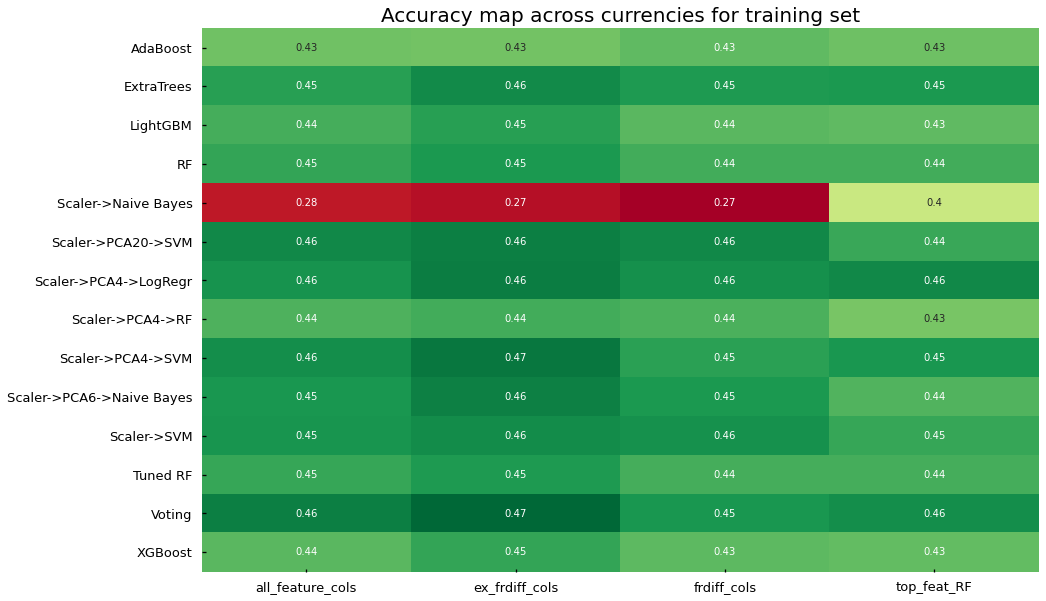

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in score_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")
plt.title(str("Accuracy map across currencies for training set"), size=20)
plt.savefig("training_accuracy1.jpg", bbox_inches='tight')
plt.savefig("training_accuracy1.pdf", bbox_inches='tight')
plt.show()


For accuracy:
- From a model perspective, it is observed that most models have a similar accuracy score with the exception of Naive Bayes classification.
- From a features perspective, we do not see a significant difference for one feature set against the others.


### Returns, Volatility and Sharp Ratio across currency pairs for training set

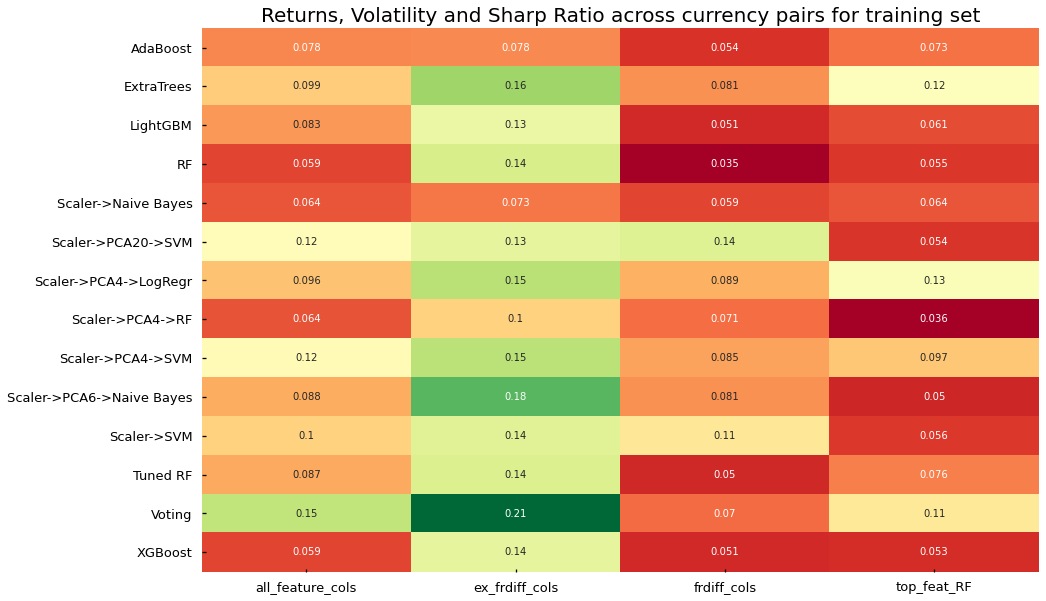

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(get_stat_means_frame(rtn_dict, 'Annual return'), annot=True, cbar=False, cmap="RdYlGn")
plt.title(str("Returns, Volatility and Sharp Ratio across currency pairs for training set"), size=20)
plt.savefig("training_return1.jpg", bbox_inches='tight')
plt.savefig("training_return1.pdf", bbox_inches='tight')
plt.show()


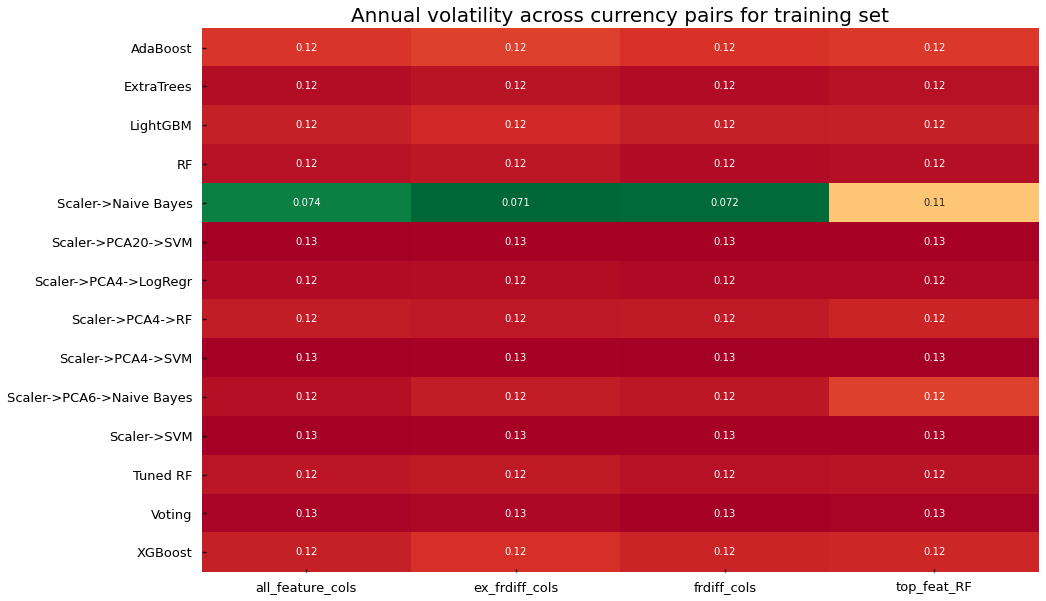

In [22]:
plt.figure(figsize=(15,10))
sns.heatmap(get_stat_means_frame(rtn_dict, 'Annual volatility'), annot=True, cbar=False, cmap="RdYlGn_r") 
plt.title(str("Annual volatility across currency pairs for training set"), size=20)
plt.savefig("training_volatility1.jpg", bbox_inches='tight')
plt.savefig("training_volatility1.pdf", bbox_inches='tight')
plt.show()


For standard deviations across currency pairs:
- From a model perspective, it is observed that Naive Bayes model gives minimal standard deviations while other models give similar level of volatility.
- From a features perspective, we do not observe significant different across features with the exception of the feature set with Naïve Bayes model.


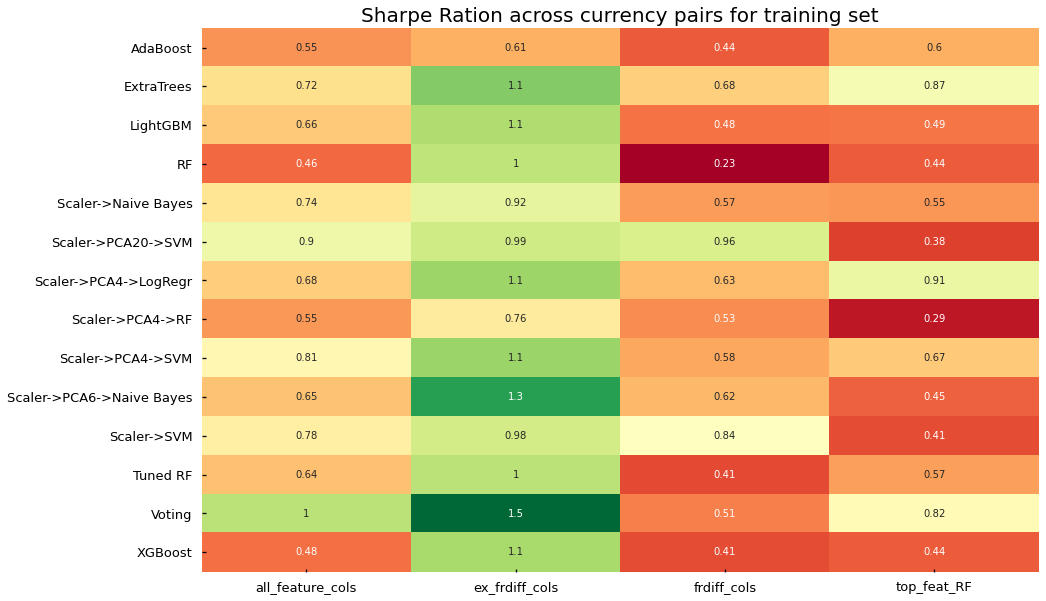

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(get_stat_means_frame(rtn_dict, 'Sharpe ratio'), annot=True, cbar=False, cmap="RdYlGn")
plt.title(str("Sharpe Ration across currency pairs for training set"), size=20)
plt.savefig("training_sharpe1.jpg", bbox_inches='tight')
plt.savefig("training_sharpe1.pdf", bbox_inches='tight')
plt.show()

For Sharpe Ratio across currency pairs:
- From a model perspective, given the volatility is largely consistent across features, similar to the observations we see from the return, extra tress, logistic regression with 4 principal components, voting classifier performs relatively better, followed by support vector machine with 20 principal components and support vector machine with 4 principal components than other algorithms.
- From a features perspective, given the volatility is largely consistent across features, it is observed that models with features without undergoing fractional differencing performs better than other feature sets.

### Returns, Volatility and Sharp Ratio across currency pairs for test set

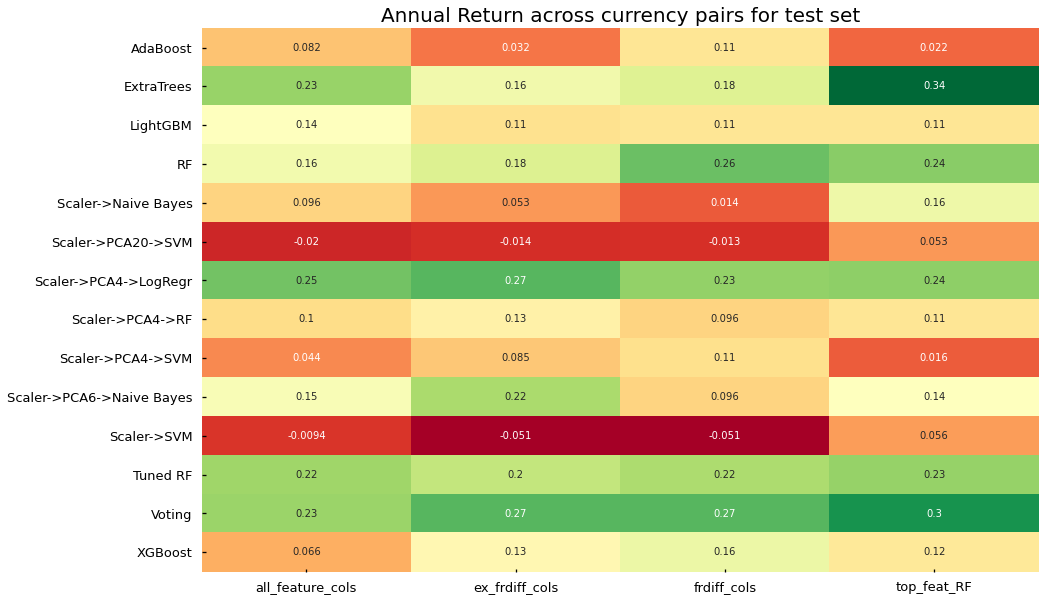

In [24]:
plt.figure(figsize=(15,10))
sns.heatmap(get_stat_means_frame(test_statistic, 'Annual return'), annot=True, cbar=False, cmap="RdYlGn")
plt.title(str("Annual Return across currency pairs for test set"), size=20)
plt.savefig("test_return1.jpg", bbox_inches='tight')
plt.savefig("test_return1.pdf", bbox_inches='tight')
plt.show()


For return across currency pairs:
- From a model perspective, it is observed that voting classifier, logistic regression with 4 principal components and extra trees as our candidate models performs well, with Voting works best, followed by logistic regression with 4 principal components and extra tress. Support vector machine with 4 principal components still gives fair prediction results while support vector machine with 20 principal components performs poorly, suggesting potential overfitting and data mining bias with 20 principal components.
- From a feature perspective, we could see models with features without undergoing fractional differencing performs fairly with other feature sets.


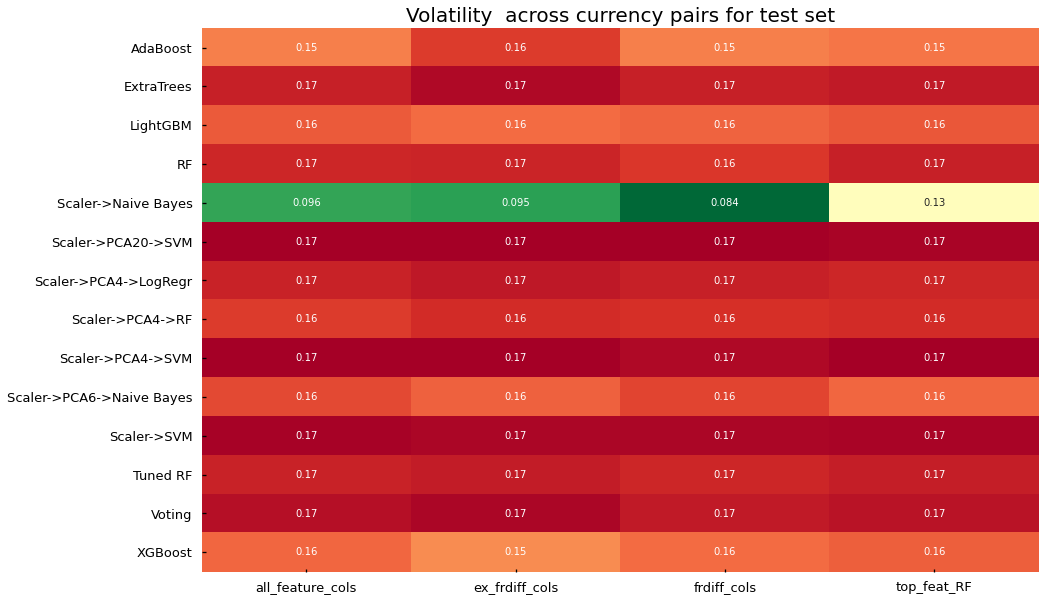

In [25]:
plt.figure(figsize=(15,10))
sns.heatmap(get_stat_means_frame(test_statistic, 'Annual volatility'), annot=True, cbar=False, cmap="RdYlGn_r")
plt.title(str("Volatility  across currency pairs for test set"), size=20)
plt.savefig("test_volatility1.jpg", bbox_inches='tight')
plt.savefig("test_volatility1.pdf", bbox_inches='tight')
plt.show()


For standard deviations across currency pairs:
- From a model perspective, similar to cross validation results, it is observed that Naive Bayes model gives minimal standard deviations while other models give similar level of volatility.
- From a features perspective, similar to cross validation results, we do not observe significant different across features with the exception of the feature set with Naïve Bayes model.


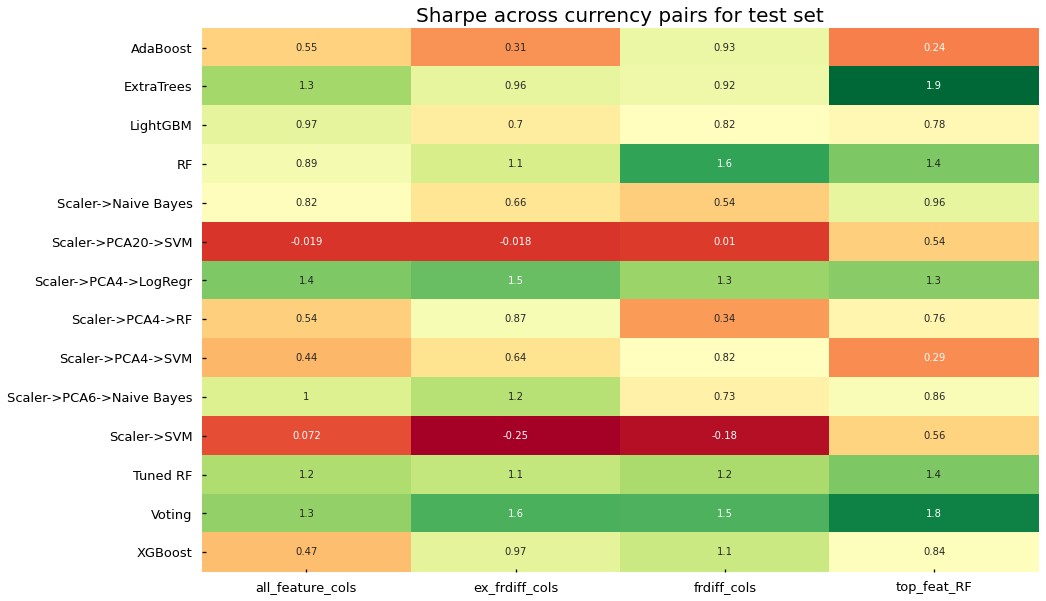

In [26]:
plt.figure(figsize=(15,10))
sns.heatmap(get_stat_means_frame(test_statistic, 'Sharpe ratio'), annot=True, cbar=False, cmap="RdYlGn")
plt.title(str("Sharpe across currency pairs for test set"), size=20)
plt.savefig("test_Sharpe1.jpg", bbox_inches='tight')
plt.savefig("test_Sharpe1.pdf", bbox_inches='tight')
plt.show()

For Sharpe Ratio across currency pairs:
- From a model perspective, given the volatility is largely consistent across features, it is observed that voting classifier, logistic regression with 4 principal components and extra trees as our candidate models performs well, with Voting works best, followed by logistic regression with 4 principal components and extra tress. Support vector machine with 4 principal components gives below-average prediction results while support vector machine with 20 principal components performs poorly, suggesting potential overfitting and data mining bias with 20 principal components.
- From a feature perspective, we could see models with features without undergoing fractional differencing performs fairly with other feature sets.

The above reinforced our observations in the cross validation during this out-of-sample testing. It is concluded the voting classifier, logistic regression with 4 principal components as our candidate models performs best while extra trees performs well in the out-sample testing, among the same set of features without undergoing fractional differencing.
Considering the consistency of model performance between validation and out-sample testing phase, we will be using voting classifier, logistic regression with 4 principal components with features without undergoing fractional differencing.

### Exploring results
Based on cross validation on the training set we would have chosen Voting classifier/ex_frdiff_colls and Logistic regression with 4PCA/ex_frdiff_colls.
Test set has confirmed that this algorithm has shown one of the best results. While some other combinations may have shown better results, it may be luck, but cross validation is evidense. 

Let's explore its returns

### Voting classifier/ex_frdiff_colls

In [27]:
#select parameteres
model = 'Voting'


features = 'ex_frdiff_cols'
print(f'Test statistics by currency for {model}')
pd.DataFrame({ticker:test_statistic[ticker][features][model] for ticker in tickers})

v = pd.DataFrame({ticker:test_statistic[ticker][features][model] for ticker in tickers})
v = v.round(decimals = 2)

Test statistics by currency for Voting


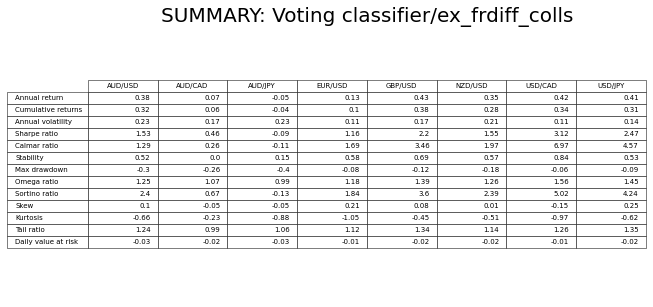

In [28]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# set fig size
fig, ax = plt.subplots(figsize=(10, 5)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
#here 
tab = table(ax, v, loc='center')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(7) 
plt.title("SUMMARY: Voting classifier/ex_frdiff_colls", size=20)
plt.xlabel("TODAY DATE TIME", size=20)
# save the result
plt.savefig("summary_voting.pdf")


######save as fig

In [29]:
from PyPDF2 import PdfFileMerger
source_dir = 'K:/2020_2431/q/fx_g10_st/'
source_dir2 = 'K:/2020_2431/q/fx_g10_st/report/'
merger = PdfFileMerger()

for item in os.listdir(source_dir):
    if item.endswith('pdf'):
        #print(item)
        merger.append(source_dir + item)

merger.write(source_dir2 + 'fx_g10_voting_strategy.pdf')       
merger.close()

Let's explore individual currency returns.

Start date,2019-02-27
End date,2020-06-17
Total months,10
,Backtest
Annual return,38.4%
Cumulative returns,31.8%
Annual volatility,22.9%
Sharpe ratio,1.53
Calmar ratio,1.29
Stability,0.52
Max drawdown,-29.9%


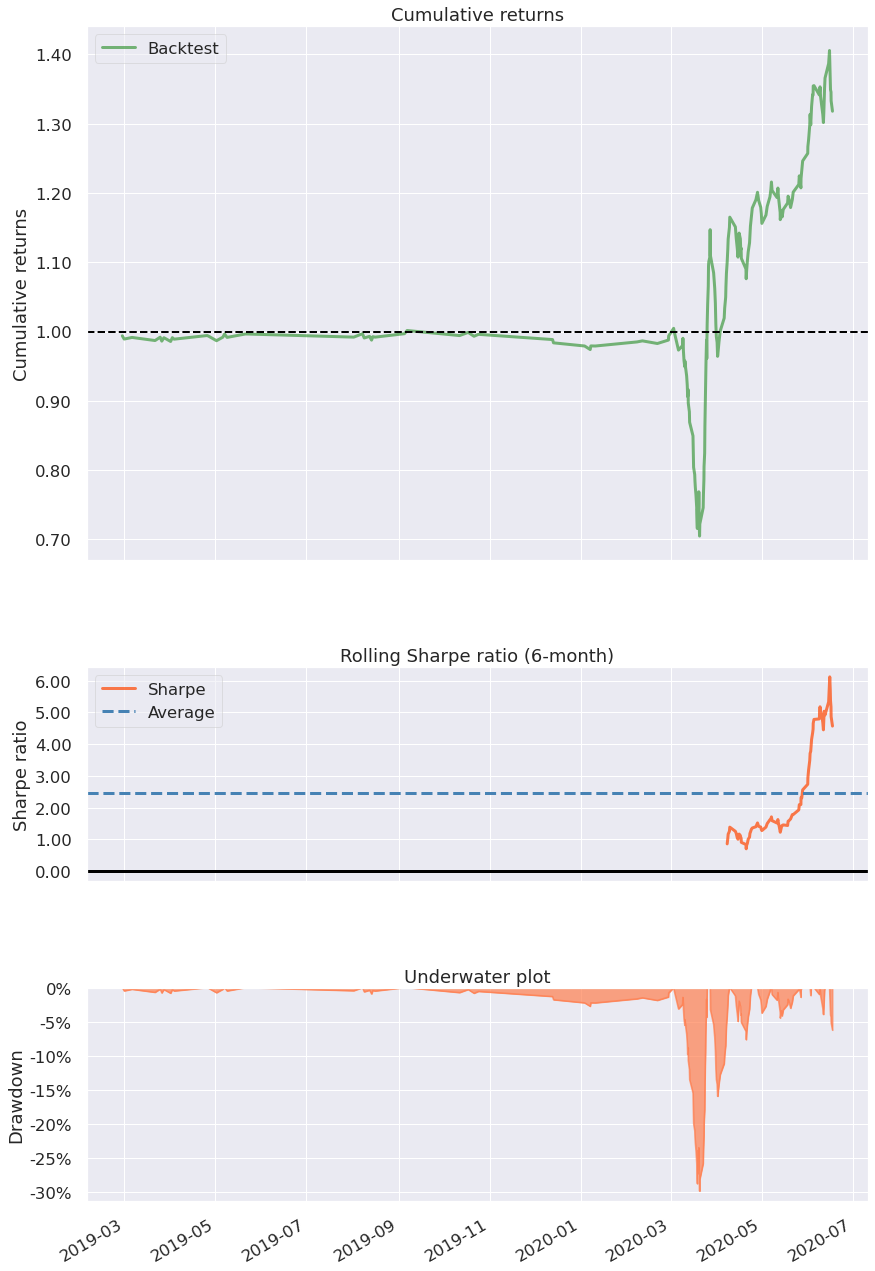

In [30]:
create_simple_tear_sheet(rtns_test['AUD/USD'][features][model])

In [31]:
#create_simple_tear_sheet(rtns_test['AUD/CAD'][features][model])

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-4.6%
Cumulative returns,-3.9%
Annual volatility,22.7%
Sharpe ratio,-0.09
Calmar ratio,-0.11
Stability,0.15
Max drawdown,-40.2%


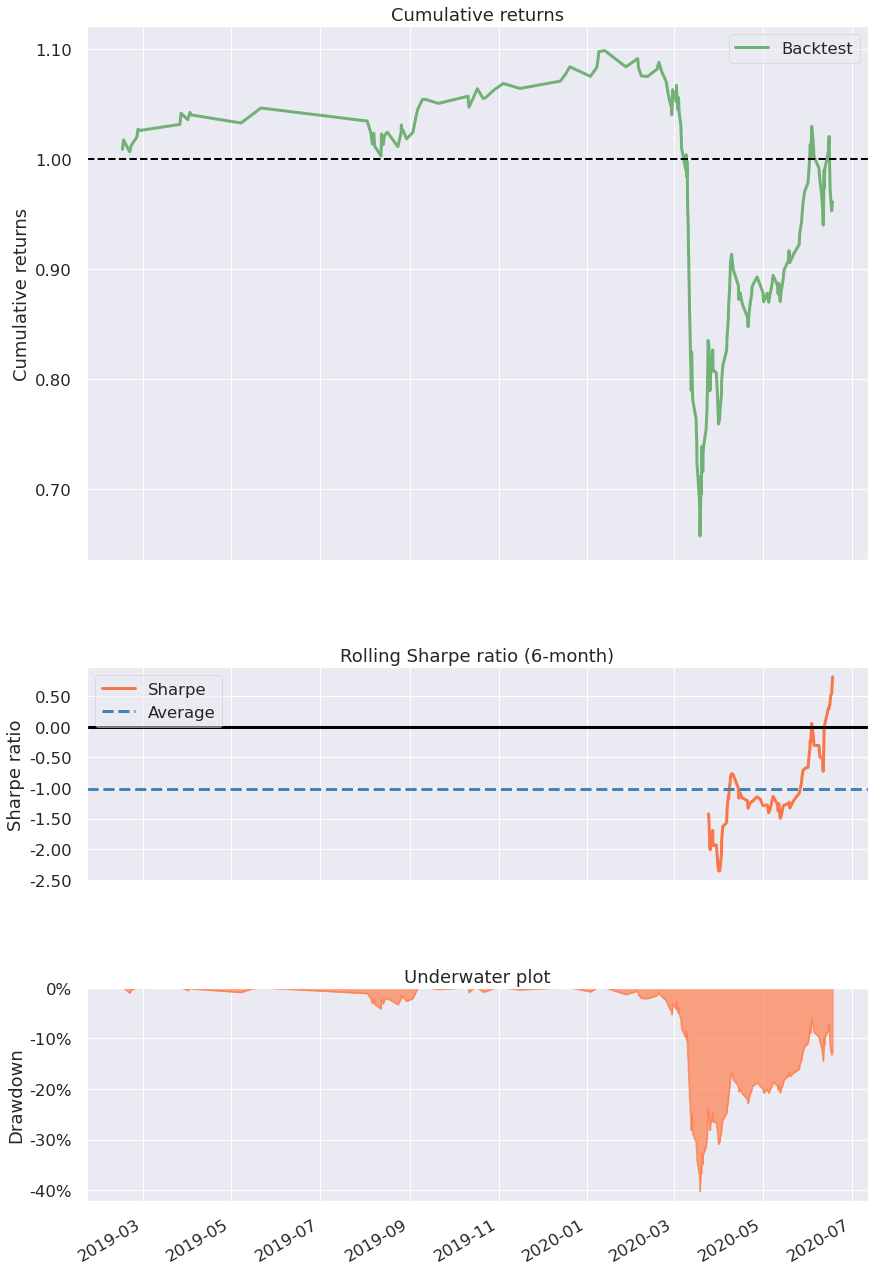

In [32]:
create_simple_tear_sheet(rtns_test['AUD/JPY'][features][model])

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,42.7%
Cumulative returns,37.9%
Annual volatility,16.8%
Sharpe ratio,2.20
Calmar ratio,3.46
Stability,0.69
Max drawdown,-12.3%


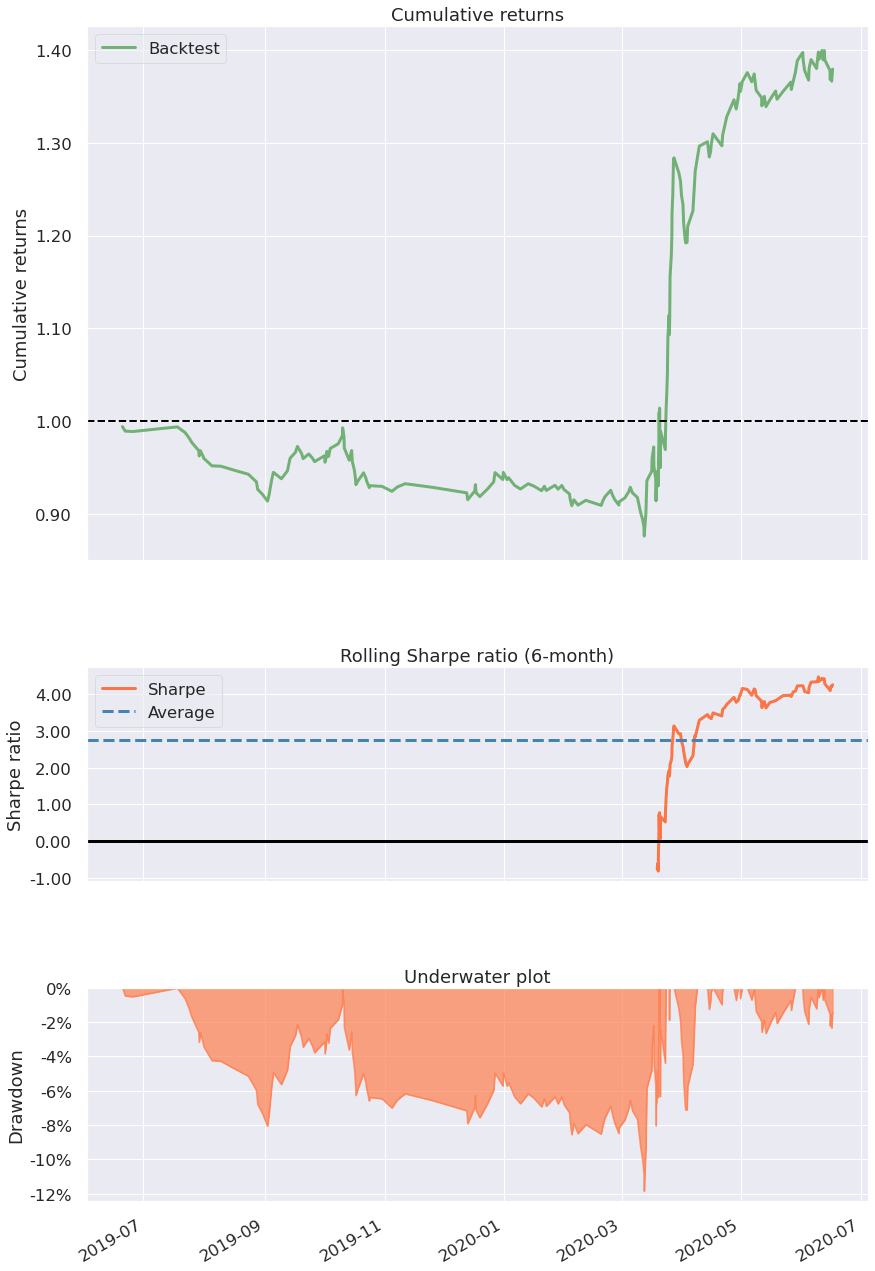

In [33]:
create_simple_tear_sheet(rtns_test['GBP/USD'][features][model])

Start date,2019-01-21
End date,2020-06-17
Total months,10
,Backtest
Annual return,34.5%
Cumulative returns,28.2%
Annual volatility,20.5%
Sharpe ratio,1.55
Calmar ratio,1.97
Stability,0.57
Max drawdown,-17.5%


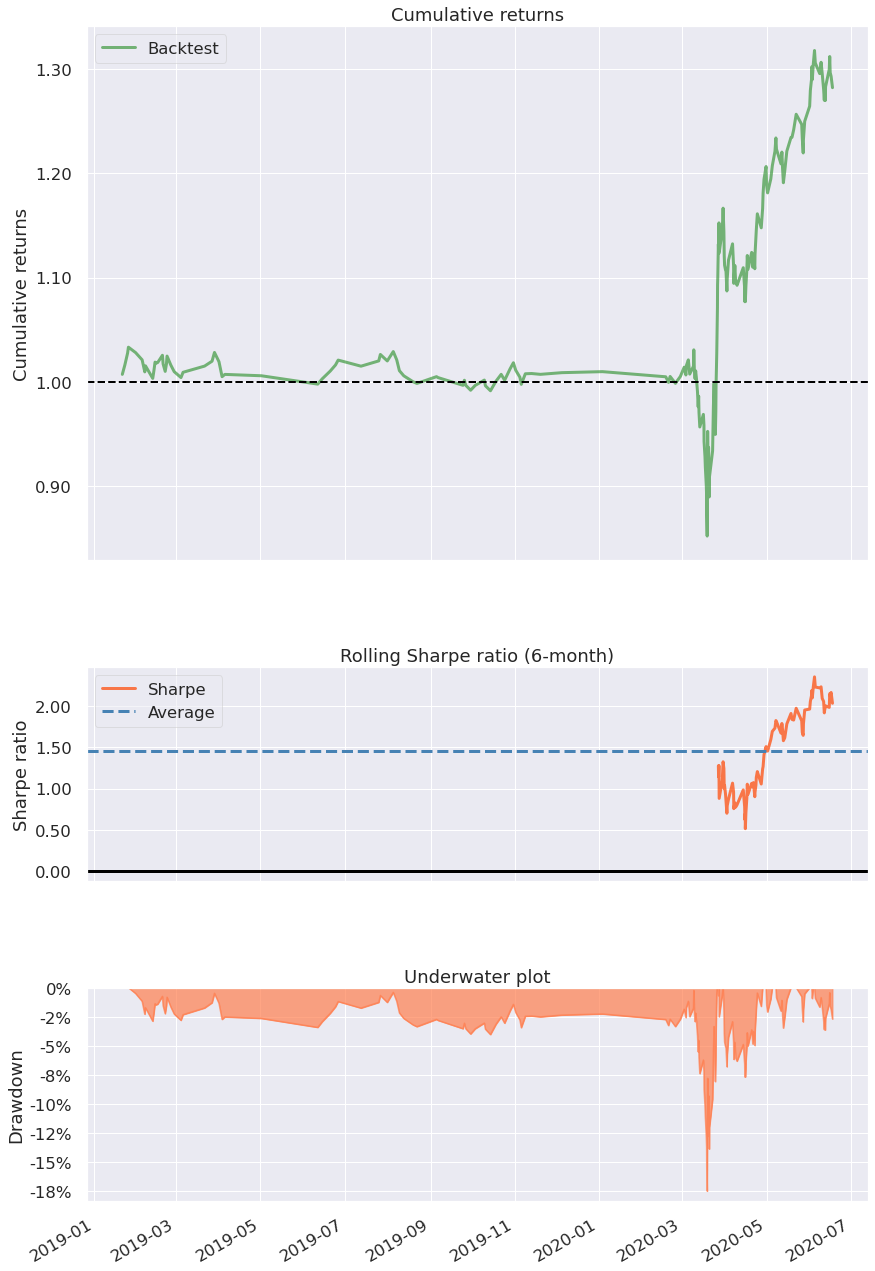

In [34]:
create_simple_tear_sheet(rtns_test['NZD/USD'][features][model])

Start date,2018-08-23
End date,2020-06-17
Total months,8
,Backtest
Annual return,13.4%
Cumulative returns,9.7%
Annual volatility,11.3%
Sharpe ratio,1.16
Calmar ratio,1.69
Stability,0.58
Max drawdown,-7.9%


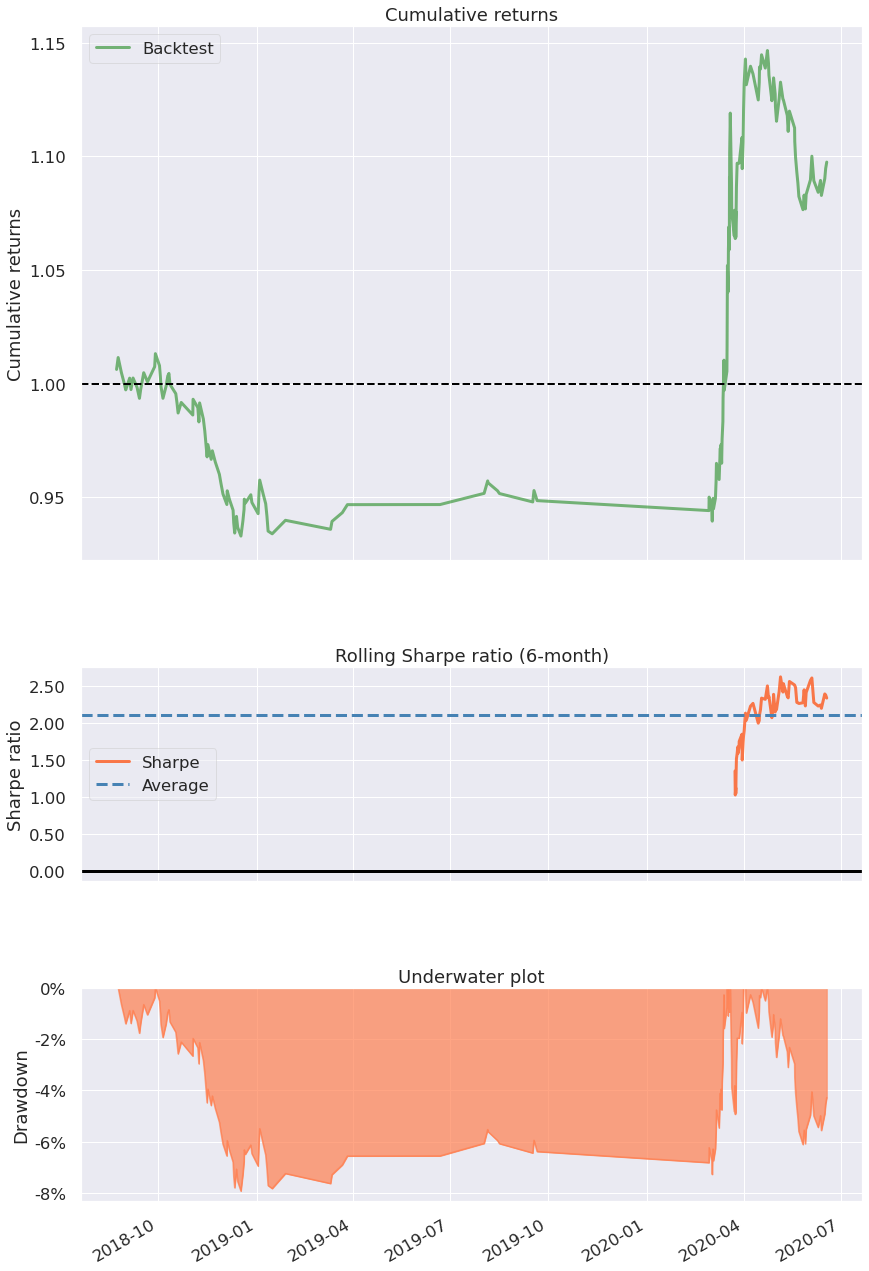

In [35]:
create_simple_tear_sheet(rtns_test['EUR/USD'][features][model])

Start date,2018-09-04
End date,2020-06-16
Total months,10
,Backtest
Annual return,41.5%
Cumulative returns,33.6%
Annual volatility,11.4%
Sharpe ratio,3.12
Calmar ratio,6.97
Stability,0.84
Max drawdown,-6.0%


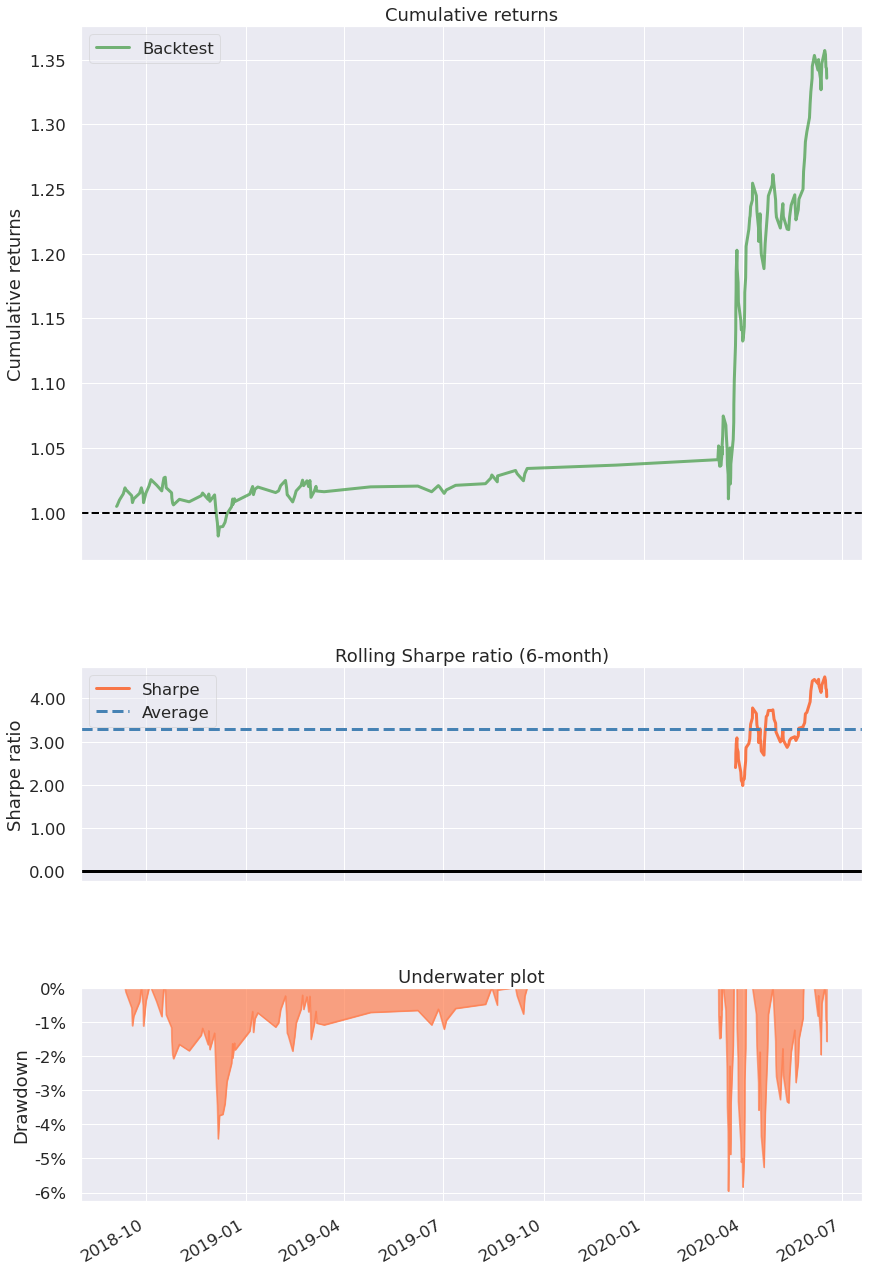

In [36]:
create_simple_tear_sheet(rtns_test['USD/CAD'][features][model])

Start date,2018-02-15
End date,2020-06-17
Total months,9
,Backtest
Annual return,41.4%
Cumulative returns,30.6%
Annual volatility,14.4%
Sharpe ratio,2.47
Calmar ratio,4.57
Stability,0.53
Max drawdown,-9.1%


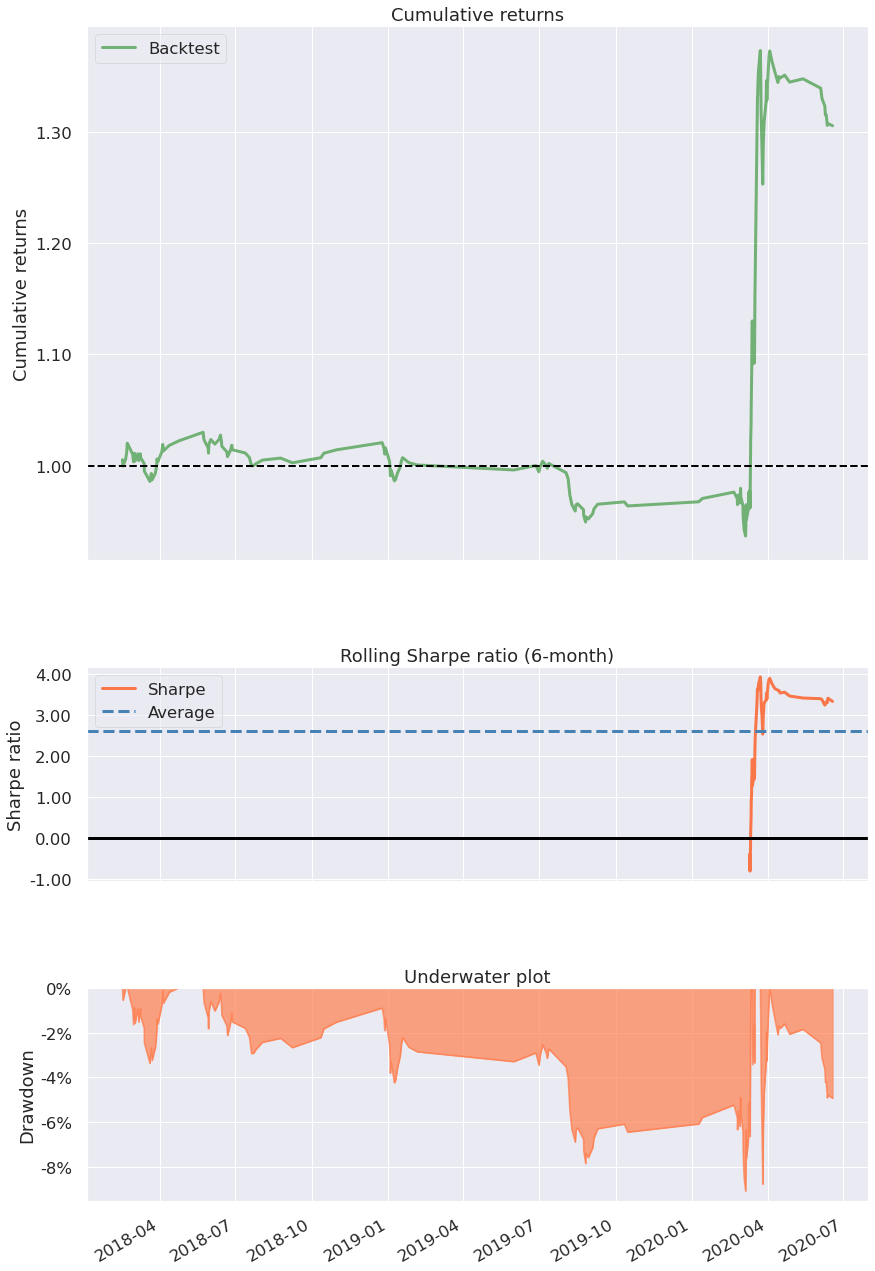

In [37]:
create_simple_tear_sheet(rtns_test['USD/JPY'][features][model])

### Logistic 4PCA/ex_frdiff_colls

In [38]:
model = 'Scaler->PCA4->LogRegr'
features = 'ex_frdiff_cols'
print(f'Test statistics by currency for {model}')
pd.DataFrame({ticker:test_statistic[ticker][features][model] for ticker in tickers})

Test statistics by currency for Scaler->PCA4->LogRegr


,AUD/USD,AUD/CAD,AUD/JPY,EUR/USD,GBP/USD,NZD/USD,USD/CAD,USD/JPY
Annual return,0.402140,0.014362,-0.036862,0.071676,0.453605,0.403155,0.229494,0.606371
Cumulative returns,0.332466,0.012470,-0.031825,0.052711,0.402734,0.327920,0.187878,0.440352
Annual volatility,0.229031,0.166429,0.209485,0.115192,0.163695,0.201345,0.114995,0.143672
Sharpe ratio,1.590511,0.168570,-0.074946,0.658251,2.368122,1.783503,1.854528,3.373436
Calmar ratio,1.347191,0.055584,-0.091733,0.778716,3.537283,2.116161,1.794286,6.929545
Stability,0.524397,0.028204,0.135752,0.474316,0.886797,0.495635,0.463273,0.782859
Max drawdown,-0.298503,-0.258384,-0.401842,-0.092044,-0.128235,-0.190512,-0.127903,-0.087505
Omega ratio,1.263580,1.026288,0.988697,1.095856,1.425733,1.299634,1.301445,1.661895
Sortino ratio,2.489441,0.237986,-0.103996,0.995390,3.797207,2.795429,2.910213,5.787861
Skew,0.091622,-0.087017,-0.053731,0.171900,-0.052159,-0.001675,0.024199,0.059960


Let's explore individual currency returns.

In [39]:
#create_simple_tear_sheet(rtns_test['AUD/USD'][features][model])

In [40]:
#create_simple_tear_sheet(rtns_test['AUD/CAD'][features][model])

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-3.7%
Cumulative returns,-3.2%
Annual volatility,20.9%
Sharpe ratio,-0.07
Calmar ratio,-0.09
Stability,0.14
Max drawdown,-40.2%


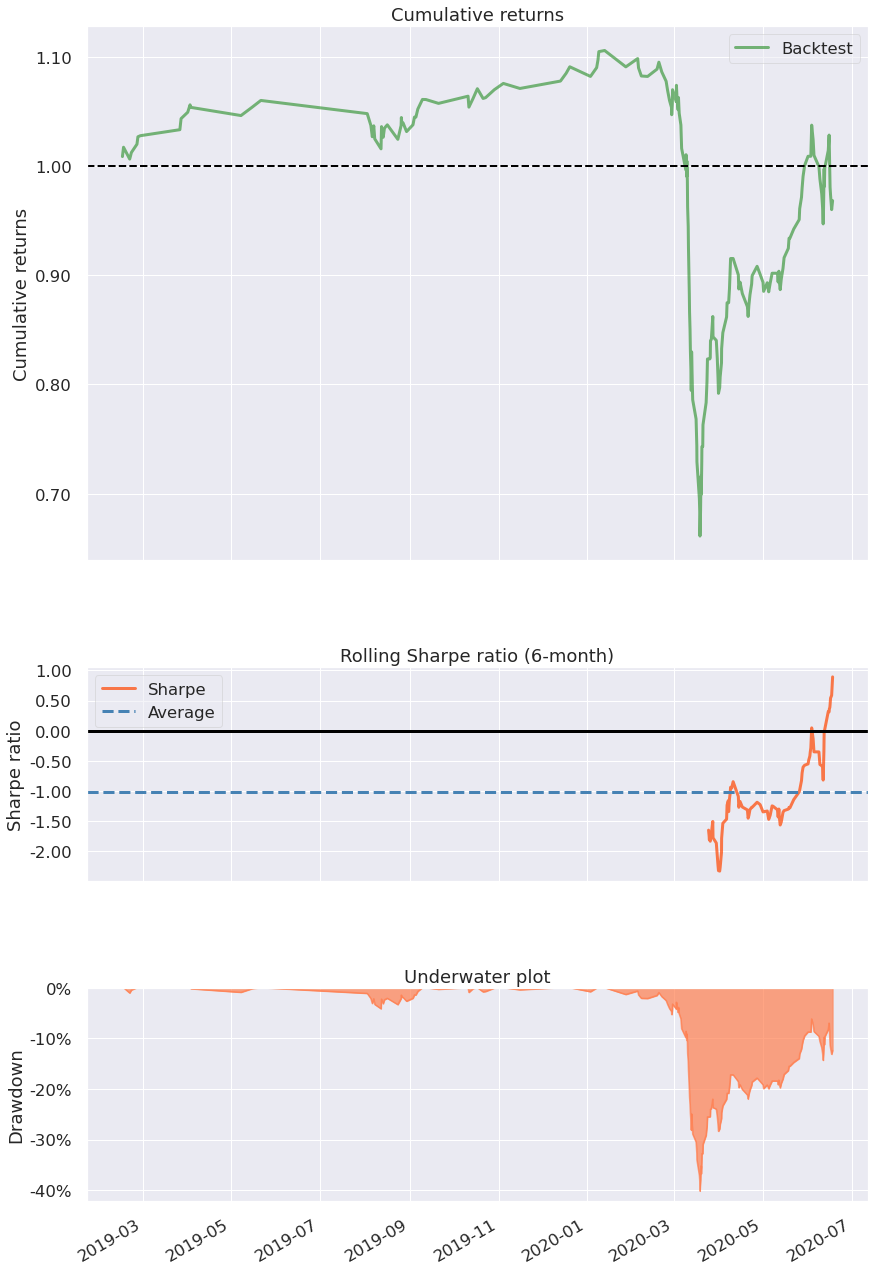

In [41]:
create_simple_tear_sheet(rtns_test['AUD/JPY'][features][model])

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,45.4%
Cumulative returns,40.3%
Annual volatility,16.4%
Sharpe ratio,2.37
Calmar ratio,3.54
Stability,0.89
Max drawdown,-12.8%


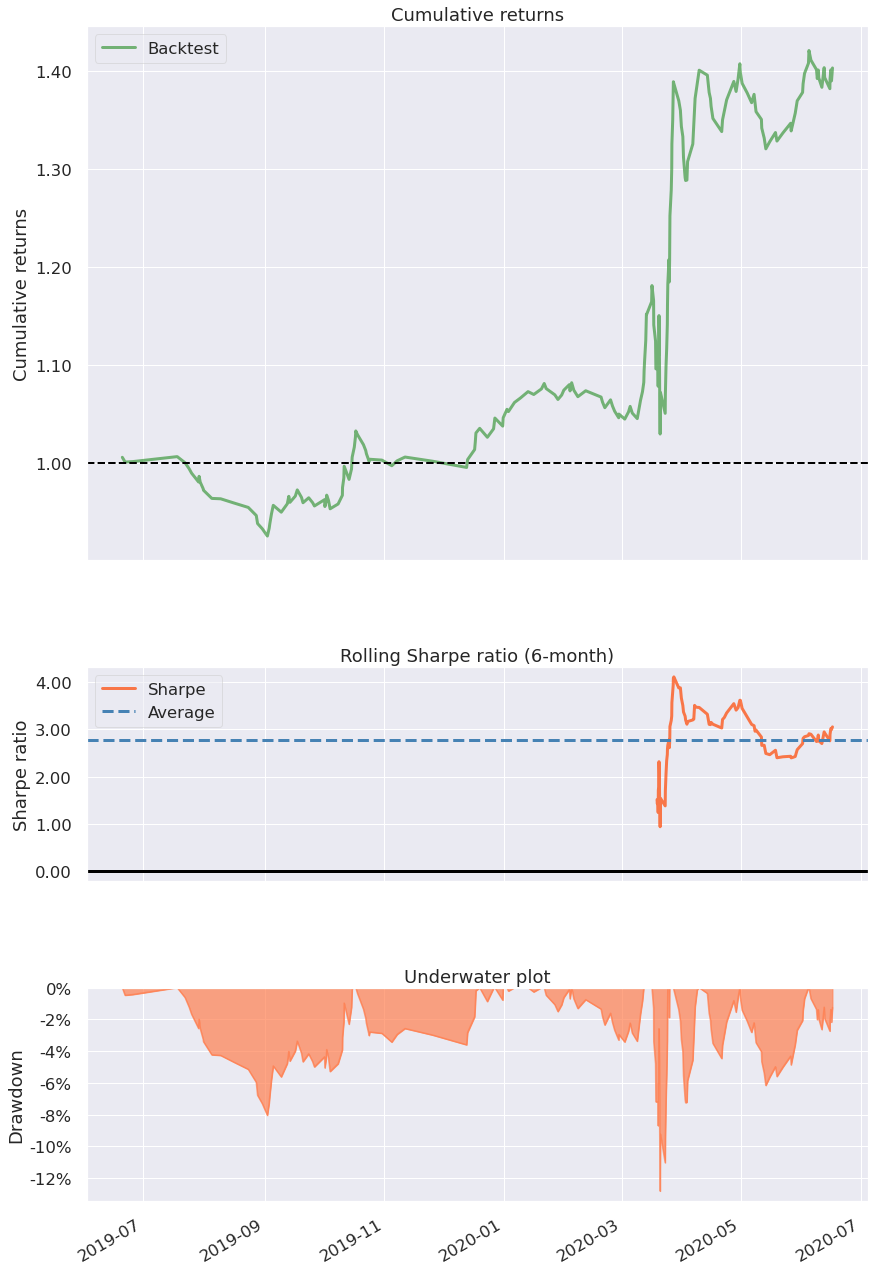

In [42]:
create_simple_tear_sheet(rtns_test['GBP/USD'][features][model])

Start date,2019-01-21
End date,2020-06-17
Total months,10
,Backtest
Annual return,40.3%
Cumulative returns,32.8%
Annual volatility,20.1%
Sharpe ratio,1.78
Calmar ratio,2.12
Stability,0.50
Max drawdown,-19.1%


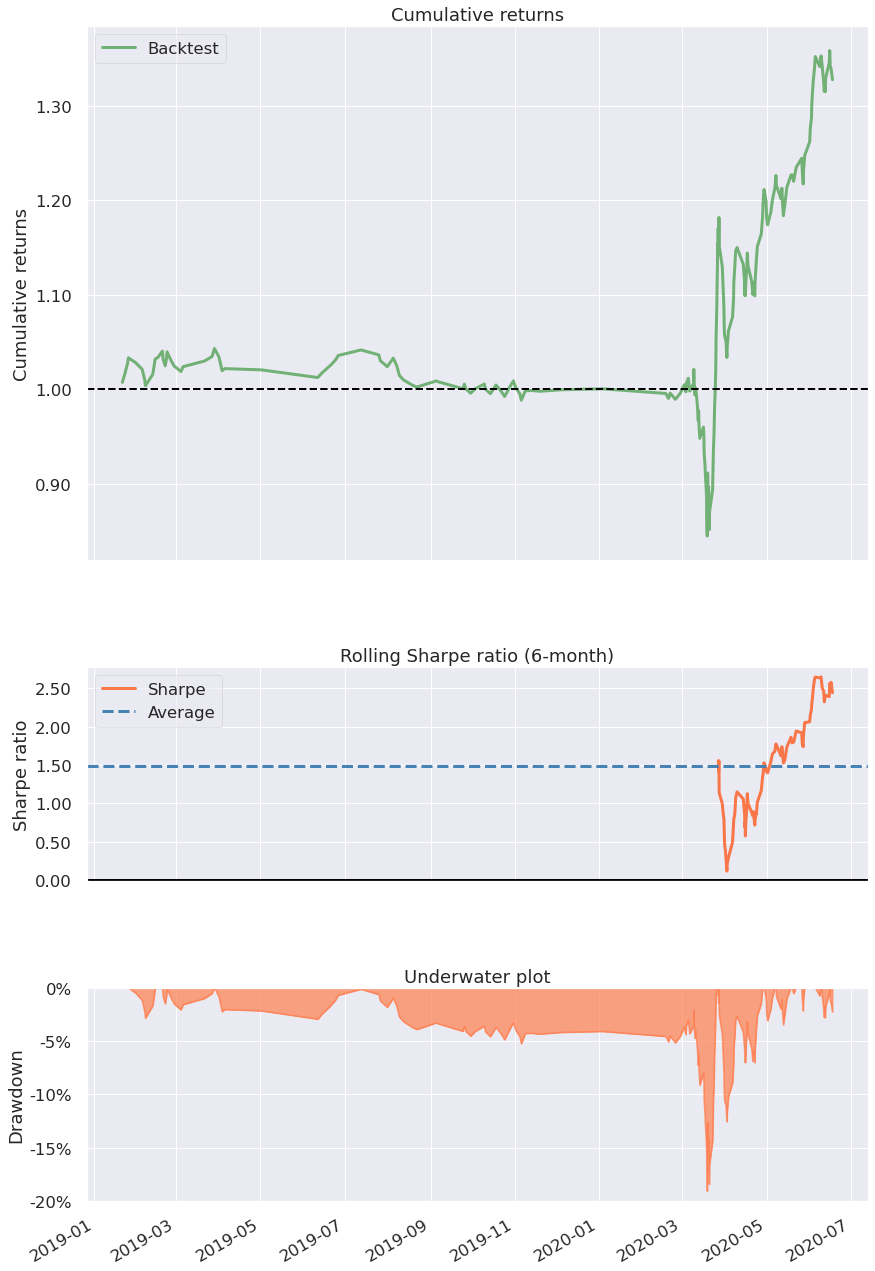

In [43]:
create_simple_tear_sheet(rtns_test['NZD/USD'][features][model])

Start date,2018-08-23
End date,2020-06-17
Total months,8
,Backtest
Annual return,7.2%
Cumulative returns,5.3%
Annual volatility,11.5%
Sharpe ratio,0.66
Calmar ratio,0.78
Stability,0.47
Max drawdown,-9.2%


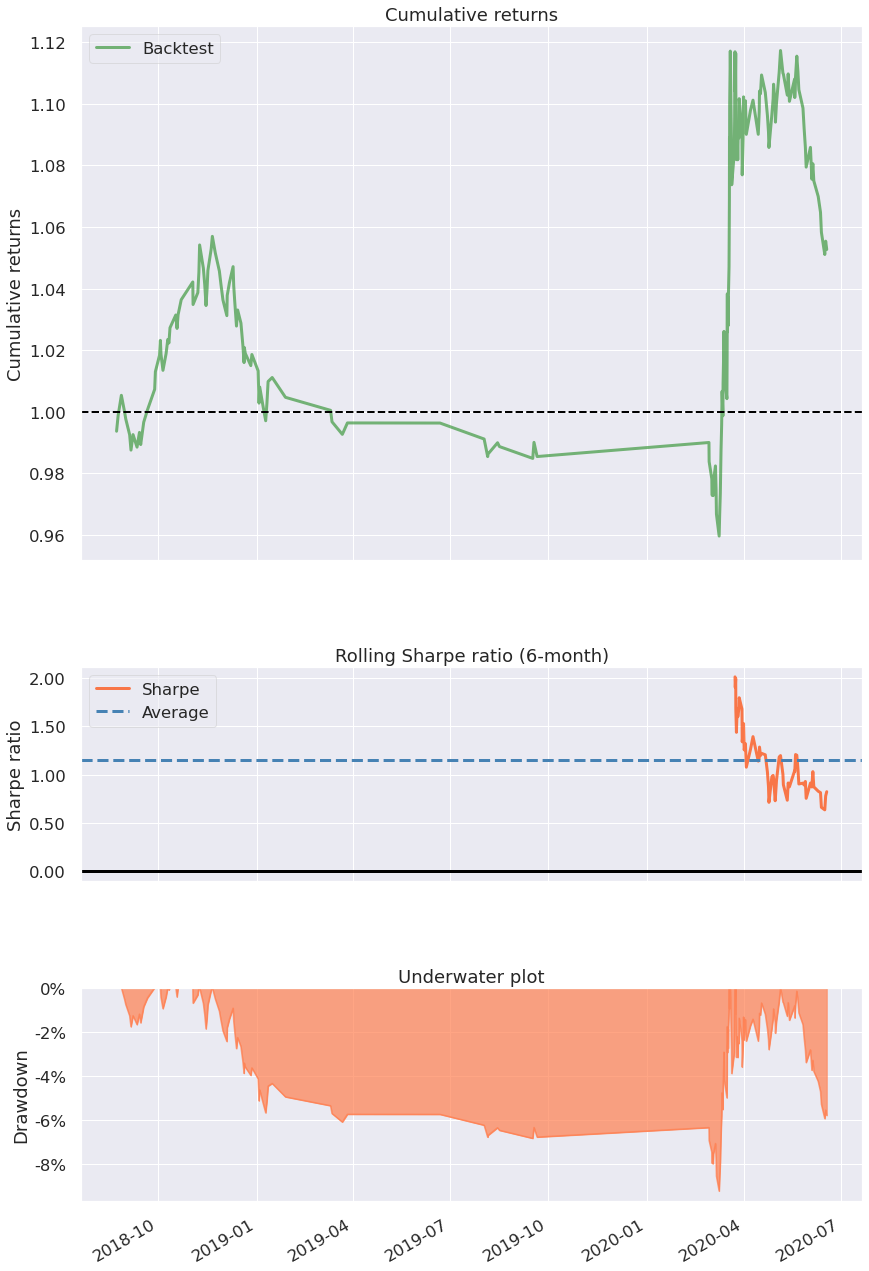

In [44]:
create_simple_tear_sheet(rtns_test['EUR/USD'][features][model])

Start date,2018-09-04
End date,2020-06-16
Total months,10
,Backtest
Annual return,22.9%
Cumulative returns,18.8%
Annual volatility,11.5%
Sharpe ratio,1.85
Calmar ratio,1.79
Stability,0.46
Max drawdown,-12.8%


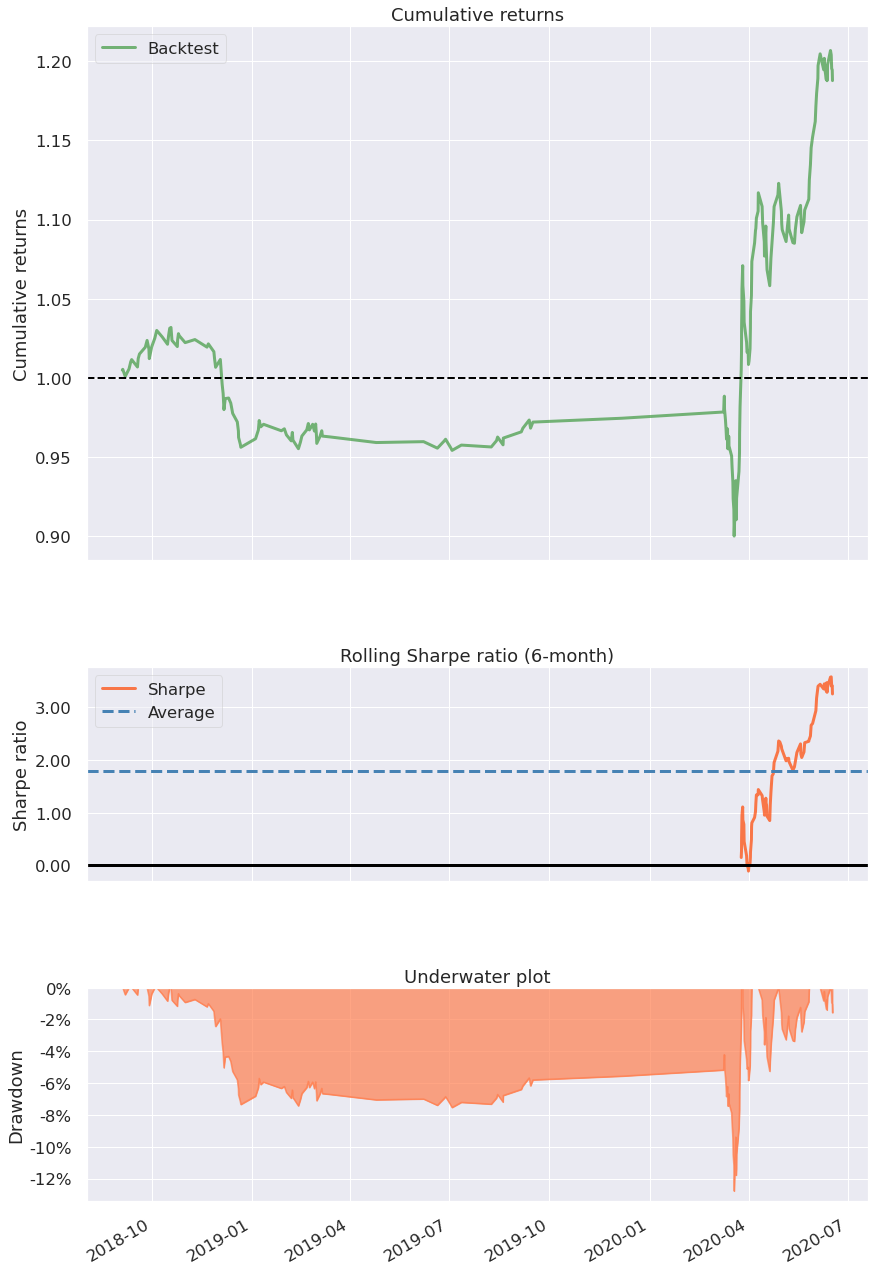

In [45]:
create_simple_tear_sheet(rtns_test['USD/CAD'][features][model])

Start date,2018-02-15
End date,2020-06-17
Total months,9
,Backtest
Annual return,60.6%
Cumulative returns,44.0%
Annual volatility,14.4%
Sharpe ratio,3.37
Calmar ratio,6.93
Stability,0.78
Max drawdown,-8.8%


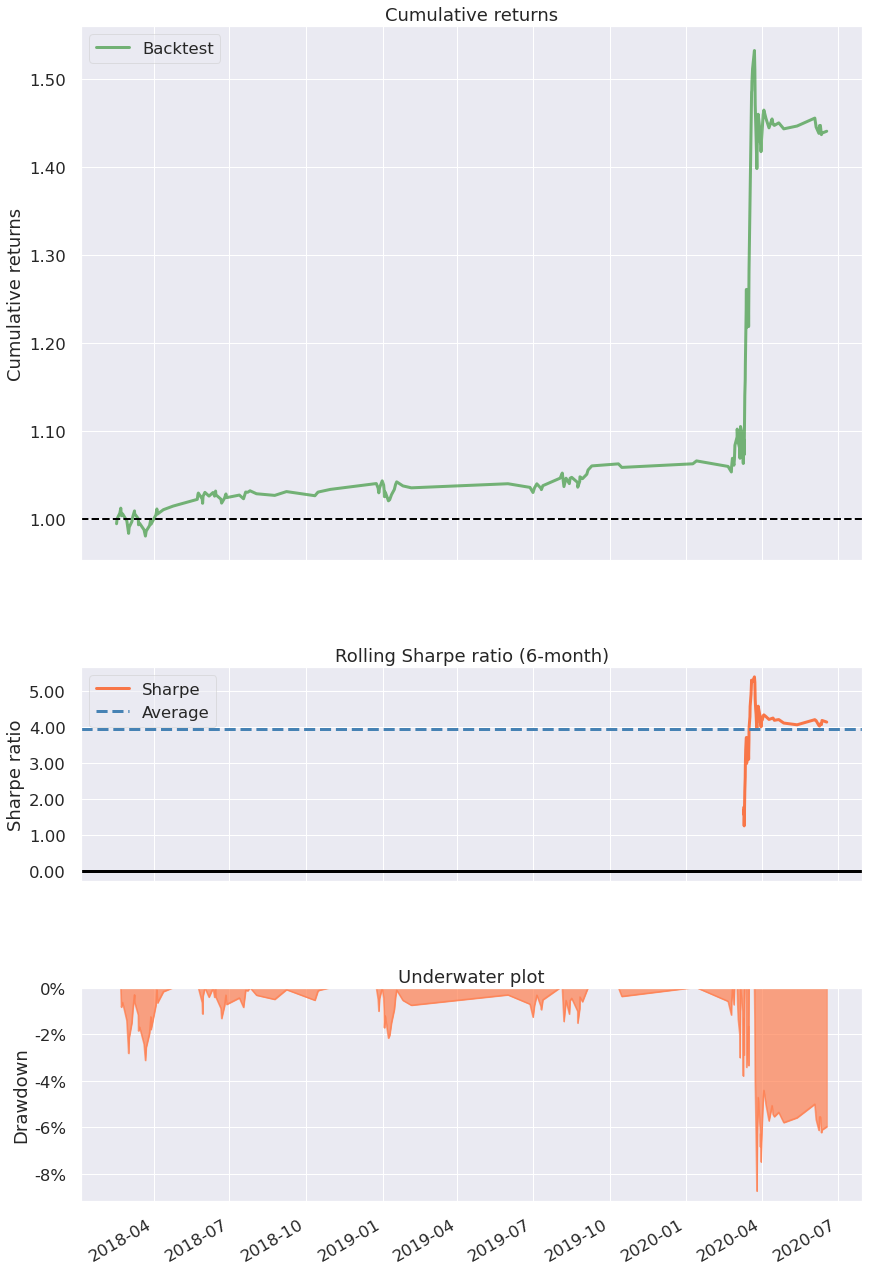

In [46]:
fig = plt.Figure()
plot1 = fig.set_canvas(create_simple_tear_sheet(rtns_test['USD/JPY'][features][model]))

As we can see, the differense in returns is coming from the COVID-19 shock. While returns come back to normal, it is worth taking into account that Drawdown can reach -40%.

### Conclusion
We managed to build the lifecycle of the ML model from getting the data to training models and generating trading signals. The test results show that the model built is showing positive performance including in stress conditions. In our case the Voting classifier based on weighted probabilities of classes from 4 other classifiers was chosen based on cross validation. Test results have shown positive performance as well.

In [47]:
jupyter nbconvert --to html notebook.ipynb  

SyntaxError: invalid syntax (<ipython-input-47-8f3684e5146c>, line 1)

In [ ]:
ipython nbconvert --to slides myfile.ipynb

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


with PdfPages('plot.pdf') as pdf:
    pdf.savefig(plot1)

    
    

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
fig.savefig('pyfolio_returns_tear_sheet.png')

In [ ]:
os.chdir('K:/2020_2431/q/fx_g10_st')
#K:\2020_2431\q\fx_g10_st\preprocessed_data
#os.chdir('K:/2020_2431/q/cds_report/images/cross_eco/report')
print(os.getcwd())

In [ ]:
fig = plt.Figure()
plot1 = fig.set_canvas(create_simple_tear_sheet(rtns_test['USD/JPY'][features][model]))

In [ ]:
# this makes plots not appear in a window
import matplotlib
matplotlib.use('Agg')


f = plt.Figure()
f = fig.set_canvas( create_simple_tear_sheet(rtns_test['USD/JPY'][features][model]) )
f.savefig('pyfolio_returns_tear_sheet.jpg')

In [ ]:

f =  pf.create_simple_tear_sheet(rtns_test['USD/JPY'][features][model],return_fig=True) 
#f=f[0][0]
f.savefig("asdasd.png",width=16,height=9,dpi=300)

In [ ]:
f =  pf.tears.create_txn_tear_sheet(rtns_test['USD/JPY'][features][model],return_fig=True) 
#f=f[0][0]
f.savefig("asdasd.png",width=16,height=9,dpi=300)

In [ ]:
f =  pf.tears.create_simple_tear_sheet(rtns_test['USD/JPY'][features][model]) 
#f=f[0][0]
f.savefig("asdasd.png",width=16,height=9,dpi=300)

In [ ]:
%%capture Jupyter notebook

In [ ]:
os.system('jupyter nbconvert --to html yourNotebook.ipynb')

In [ ]:
jupyter-nbconvert --to pdfviahtml example.ipynb

In [ ]:
python -m pip install -U notebook-as-pdf
pyppeteer-install

In [ ]:
pip install -U notebook-as-pdf

In [ ]:
pip install pyppeteer

In [ ]:
jupyter-nbconvert --to pdfviahtml WQU Capstone - Notebook 7 - Training and testing vA.ipynb

In [ ]:
nbconvert wwwwq.ipynb --to html --output wwwwq.html

In [ ]:
import nbconvert

In [ ]:
#https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/issues/6